In [11]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models
from matplotlib.patches import Rectangle
import csv

In [12]:
data_root = ".\\dataset"
print(os.listdir(data_root))

['test', 'train', 'train_data.csv']


In [13]:
train_dir = "train"
val_dir = "val"
class_names = ["is_human", "no"]

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, train_dir, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        img = cv2.imread(os.path.join(source_dir, file_name), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        cv2.imwrite(os.path.join(dest_dir, file_name), img)

100%|██████████| 3/3 [00:00<00:00, 54.32it/s]


In [14]:
!ls train

is_human
no


In [15]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [16]:
xc = []
yc = []
w = []
h = []

with open(os.path.join(data_root, "train_data.csv"), 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        xc.append(float(row[1]))
        yc.append(float(row[2]))
        w.append(float(row[3]))
        h.append(float(row[4]))

In [33]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        # tuple_with_path = (original_tuple + (path,))
        # tuple_new = (original_tuple + (xc[index], yc[index], w[index], h[index],))
        if original_tuple[1] == 1:
            tuple_new = (original_tuple + (-1, -1, -1, -1,))
        elif original_tuple[1] == 0:
            # tuple_new = (original_tuple + (xc[index], yc[index], w[index], h[index],))
            id = int(path.split("\\")[2].replace(".jpg", ""))
            tuple_new = (original_tuple + (xc[id], yc[id], w[id], h[id],))
        # return tuple_with_path
        return tuple_new

In [43]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
# val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)
train_dataset = ImageFolderWithPaths(train_dir, train_transforms)
val_dataset = ImageFolderWithPaths(val_dir, val_transforms)

print(train_dataset.samples)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

[('train\\is_human\\1.jpg', 0), ('train\\is_human\\2.jpg', 0), ('train\\no\\1.jpg', 1), ('train\\no\\2.jpg', 1)]


In [44]:
len(train_dataloader), len(train_dataset)

(1, 4)

In [39]:
def show_input(input_tensor, title='', num_batch=0, num_elem_batch=0):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    image = image.clip(0, 1)
    plt.imshow(image)
    rect = Rectangle((50, 50), 150, 150, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.title(str(num_batch) + "." + str(num_elem_batch) + ") " + title)
    plt.show()
    plt.pause(0.001)

# def show_input_all(dataloader):
#     it = iter(dataloader)
#     for i in range(len(dataloader)):
#         X_batch, y_batch, paths = next(it)
#         print(y_batch)
#         print(paths)
#         num_elem_batch = 0
#         for x_item, y_item in zip(X_batch, y_batch):
#             show_input(x_item, title=class_names[y_item], num_batch=i+1, num_elem_batch=num_elem_batch+1)
#             num_elem_batch += 1

def show_input_all(dataloader):
    it = iter(dataloader)
    for i in range(len(dataloader)):
        X_batch, y_batch, xc_batch, yc_batch, w_batch, h_batch = next(it)
        print("y_batch:", y_batch)
        print("xc_batch:", xc_batch)
        print("yc_batch:", yc_batch)
        print("w_batch:", w_batch)
        print("h_batch:", h_batch)
        num_elem_batch = 0
        for x_item, y_item in zip(X_batch, y_batch):
            show_input(x_item, title=class_names[y_item], num_batch=i+1, num_elem_batch=num_elem_batch+1)
            num_elem_batch += 1

y_batch: tensor([0, 1, 0, 1])
xc_batch: tensor([ 0.9000, -1.0000,  0.4000, -1.0000], dtype=torch.float64)
yc_batch: tensor([ 0.2000, -1.0000,  0.8000, -1.0000], dtype=torch.float64)
w_batch: tensor([ 1., -1., 12., -1.], dtype=torch.float64)
h_batch: tensor([ 3., -1., 15., -1.], dtype=torch.float64)


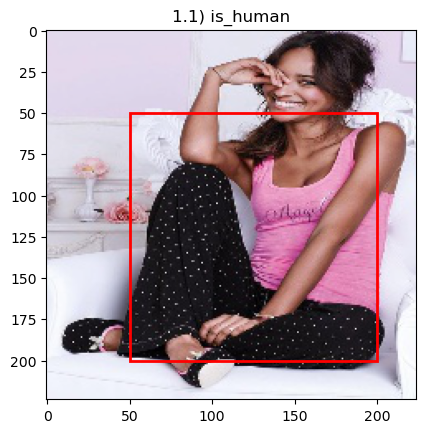

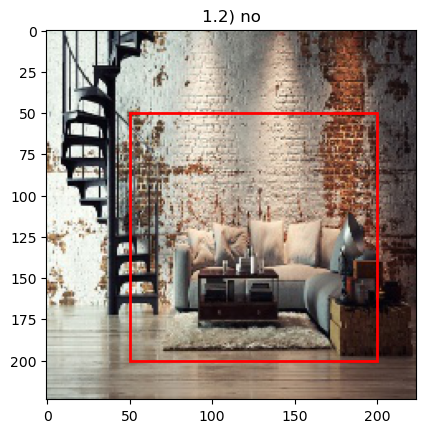

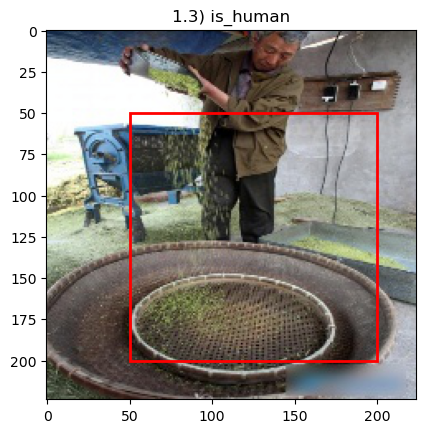

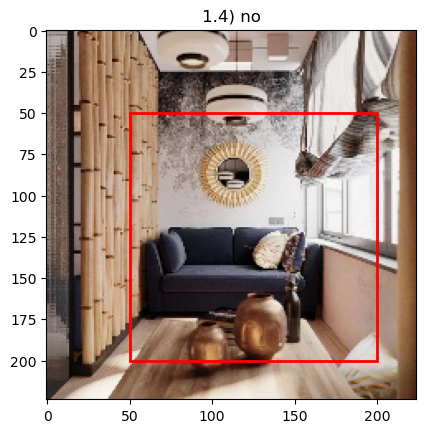

In [48]:
show_input_all(train_dataloader)

y_batch: tensor([0, 1])
xc_batch: tensor([ 0.3000, -1.0000], dtype=torch.float64)
yc_batch: tensor([ 0.6000, -1.0000], dtype=torch.float64)
w_batch: tensor([ 7., -1.], dtype=torch.float64)
h_batch: tensor([19., -1.], dtype=torch.float64)


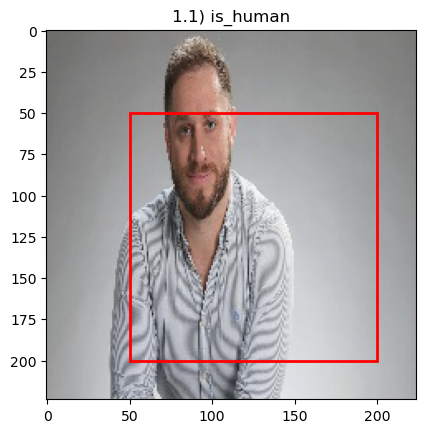

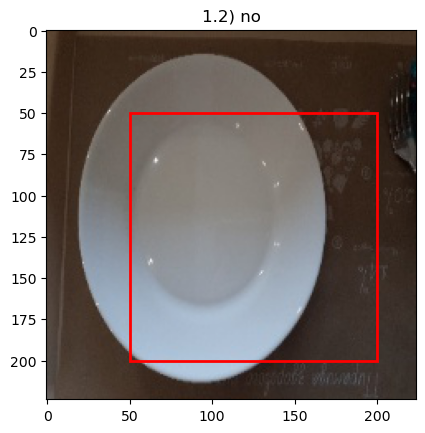

In [46]:
show_input_all(val_dataloader)

In [9]:
# xc = []
# yc = []
# w = []
# h = []

# with open(os.path.join(data_root, "train_data.csv"), 'r') as csvfile:
#     csvreader = csv.reader(csvfile)
#     next(csvreader)
#     for row in csvreader:
#         xc.append(float(row[1]))
#         yc.append(float(row[2]))
#         w.append(float(row[3]))
#         h.append(float(row[4]))

# for i in range(len(xc)):
#     print(xc[i])
#     print(yc[i])
#     print(w[i])
#     print(h[i])
#     print("--------------------")

0.3
0.6
7.0
19.0
--------------------
0.9
0.2
1.0
3.0
--------------------
0.4
0.8
12.0
15.0
--------------------


In [40]:
# for class_name in class_names:
#     source_dir = os.path.join(train_dir, class_name)
#     for file_name in tqdm(os.listdir(source_dir)):
#         img = cv2.imread(os.path.join(source_dir, file_name), cv2.IMREAD_COLOR)
#         # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (224, 224))
#         # for x, y, width, height in faces:
#         #     cv2.rectangle(img, (x, y), (x + width, y + height), color=(255, 0, 0), thickness=2)   
#         cv2.imwrite(os.path.join(source_dir, "resized_224_" + file_name), img)

100%|██████████| 1/1 [00:00<00:00, 151.87it/s]


In [10]:
!rm -rf train val test